# Measure rings

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

In [2]:
config = TreeRing.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/treering")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load last weights
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

W0819 16:24:48.877007 4585690560 deprecation_wrapper.py:119] From /Users/miroslav.polacek/anaconda3/envs/TreeRingCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 16:24:48.898869 4585690560 deprecation_wrapper.py:119] From /Users/miroslav.polacek/anaconda3/envs/TreeRingCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 16:24:48.903666 4585690560 deprecation_wrapper.py:119] From /Users/miroslav.polacek/anaconda3/envs/TreeRingCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 16:24:48.923855 4585690560 deprecation_wrapper.py:119] From /Users/miroslav.polacek/anaconda3/envs/TreeRingCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.p

Loading weights  /Users/miroslav.polacek/Dropbox (VBC)/Group Folder Swarts/Research/CNNRings/Mask_RCNN/logs/treering20190723T1412/mask_rcnn_treering_0010.h5
Re-starting from epoch 10


##  Class Names

In [4]:
class_names = ['BG', 'ring']

## Run Object Detection

Processing 1 images
image                    shape: (2208, 2752, 3)       min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


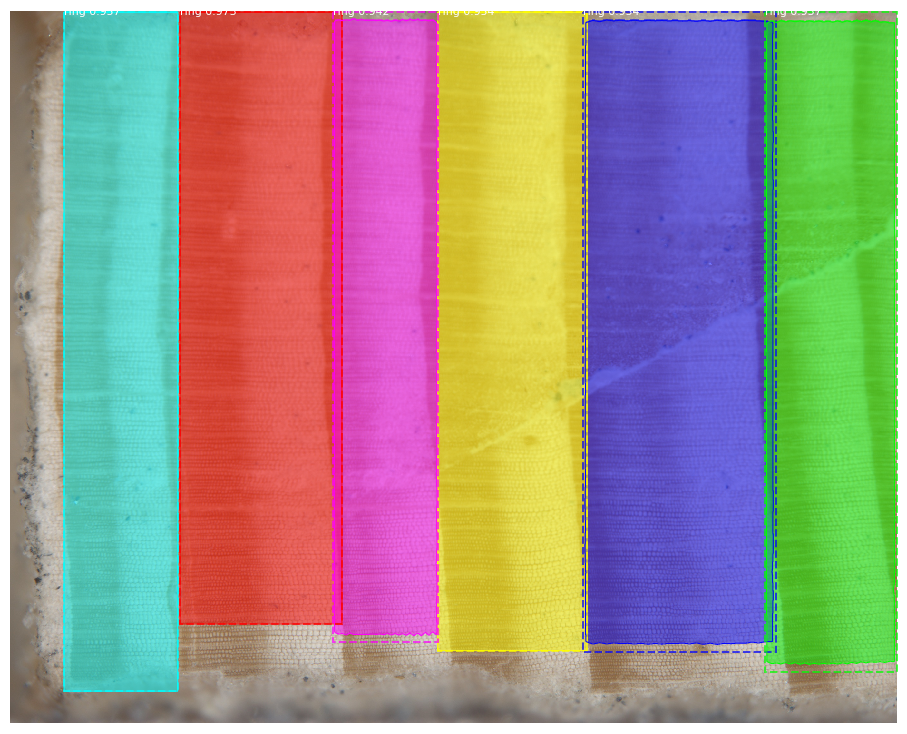

In [8]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Get mask

In [30]:
masks = r['masks']

In [ ]:
masks.shape

In [31]:
masks.shape[2] #gives number of detected mask

6

In [45]:
firstmask = masks[:,:,0]
firstmask3 = firstmask[:,:, np.newaxis] #reshape to try with visualise 
firstmask3.shape

(2208, 2752, 1)

In [58]:
visualize.display_instances(image,boxes = r['rois'][0], masks = r['masks'][:,:,0], class_ids = r['class_ids'][0], class_names = class_names)

AssertionError: 

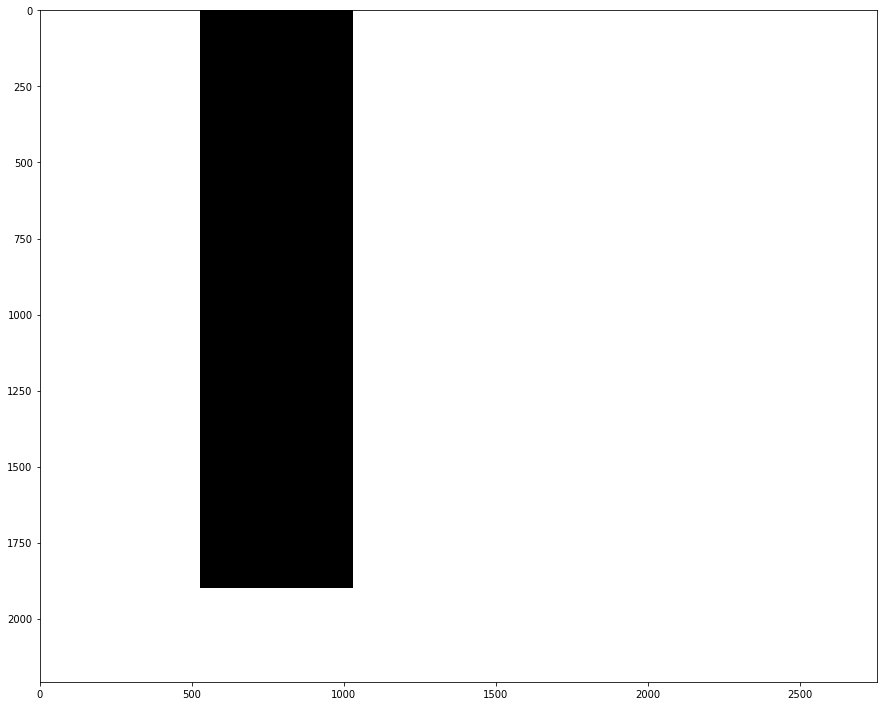

In [74]:
#plt.imshow(image)
plt.figure(figsize = (15, 15))
plt.imshow(firstmask, cmap='binary')

## 1) Experiment with shapely

In [118]:
#get plygon out of mask
from skimage import color, measure
from shapely.geometry import shape, Point, Polygon, LineString
import cv2

intmask = firstmask.astype(int)
contours = measure.find_contours(intmask, level=0.9)

# build polygon
# this assumes a single, contiguous shape
# if you have e.g. multiple shapes, build a MultiPolygon with a list comp

# RESULTING POLYGONS ARE NOT GUARANTEED TO BE SIMPLE OR VALID
# check this yourself using e.g. poly.is_valid

poly = Polygon(contours[0])


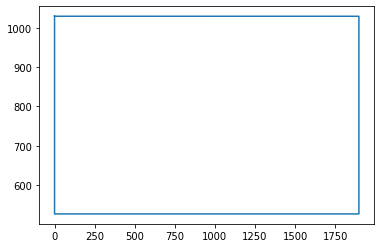

In [119]:
x,y = poly.exterior.xy #there is also something like exterior coords
plt.plot(x,y)

(-94.905, 1993.0049999999999, 501.78999999999996, 1054.2099999999998)

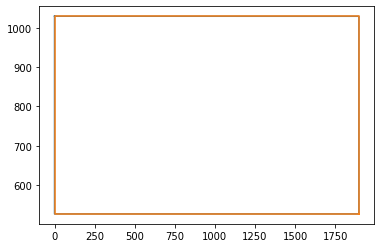

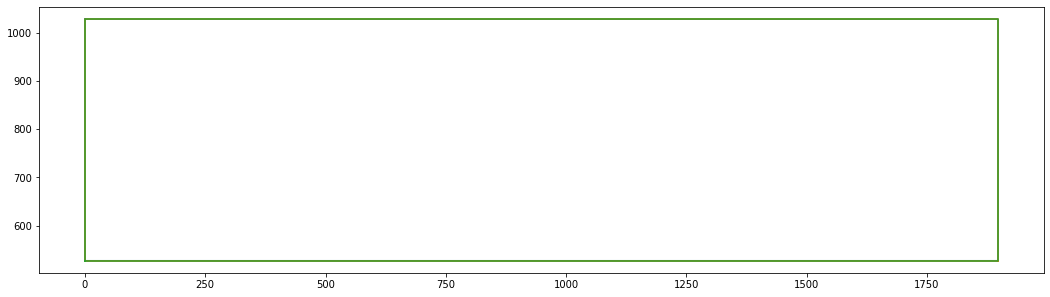

In [127]:
#get minimum rotated rectangle and plot all togather
mrrPoly = poly.minimum_rotated_rectangle
recx, recy = mrrPoly.exterior.xy
plt.plot(x,y)
plt.plot(recx, recy)#unfortunately here it does not show too much because it is overlaping, on real example it worked
# try to get angles of this
poly.area # calculates the area of polygon object
poly.length

poly = Polygon(contours[0])
plt.figure(figsize = (18, 15))
x,y = poly.exterior.xy
plt.plot(x,y)
recx, recy = poly.minimum_rotated_rectangle.exterior.xy
plt.plot(recx, recy)
envx, envy = poly.envelope.exterior.xy
plt.plot(envx, envy)
plt.axis('scaled')

In [ ]:
#get the minimal
from shapely.geometry import Polygon, LineString

# get the minimum bounding rectangle and zip coordinates into a list of point-tuples
mbr_points = list(zip(*polygon.minimum_rotated_rectangle.exterior.coords.xy))

# calculate the length of each side of the minimum bounding rectangle
mbr_lengths = [LineString((mbr_points[i], mbr_points[i+1])).length for i in range(len(mbr_points) - 1)]

# get major/minor axis measurements
minor_axis = min(mbr_lengths)
major_axis = max(mbr_lengths)
Shapely makes it easy to compute the mbr via minimum_rotated_rectangle, but it doesn't appear that the opposite sides are of exact equal length. Because of this, the above calculates the length of each side, then takes the min/max.

'/Users/miroslav.polacek/Dropbox (VBC)/Group Folder Swarts/Research/CNNRings/Mask_RCNN/samples/TreeRing'